In [258]:
from scripts.fid.inception import InceptionV3
import glob
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from scripts.fid.fid import calculate_frechet_distance
from src.freq_math import fourier_power_divergence, wavelet_packet_power_divergence

In [246]:
img_test1 = Image.open('/home/lveerama/HPCA/CelebA-HQ/data256x256/00001.jpg')
img_test2 = Image.open('/home/lveerama/HPCA/CelebA-HQ/data256x256/00002.jpg')
img_test3 = Image.open('/home/lveerama/HPCA/CelebA-HQ/data256x256/00003.jpg')
img_test4 = Image.open('/home/lveerama/HPCA/CelebA-HQ/data256x256/00004.jpg')
img_test5 = Image.open('/home/lveerama/HPCA/CelebA-HQ/data256x256/00005.jpg')

In [255]:
def rotate_values(img_test, angle, n=10, crop=64):
    imgr_test = transforms.functional.rotate(img_test, angle, expand=False)
    img_test = transforms.functional.center_crop(img_test, output_size=crop)
    imgr_test = transforms.functional.center_crop(imgr_test, output_size=crop)
    # plt.figure()
    # plt.subplot(1, 2, 1)
    # plt.imshow(img_test)
    # plt.axis('off')
    # plt.subplot(1, 2, 2)
    # plt.imshow(imgr_test)
    # plt.axis('off')
    # plt.show()
    img_tensor = transforms.ToTensor()(img_test)
    imgr_tensor = transforms.ToTensor()(imgr_test)
    img_tensor = torch.stack([img_tensor]*n, dim=0)
    imgr_tensor = torch.stack([imgr_tensor]*n, dim=0)
    # print(img_tensor.shape, imgr_tensor.shape)
    bidx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([bidx])
    op1 = model(img_tensor)[0]
    op2 = model(imgr_tensor)[0]
    onp1 = op1.squeeze(3).squeeze(2).cpu().numpy()
    onp2 = op2.squeeze(3).squeeze(2).cpu().numpy()
    m1, s1 = np.mean(onp1, axis=0), np.cov(onp1, rowvar=False)
    m2, s2 = np.mean(onp2, axis=0), np.cov(onp2, rowvar=False)
    fid = calculate_frechet_distance(m1, s1, m2, s2)
    fa, fb = fourier_power_divergence(img_tensor, imgr_tensor)
    pa, pb = wavelet_packet_power_divergence(img_tensor, imgr_tensor, level=2)
    return fid, (fa.item(), fb.item()), (pa.item(), pb.item())


def gaussian_values(img_test, factor, n=10):
    img_tensor = transforms.ToTensor()(img_test)
    imgr_tensor = (1 - factor) * img_tensor + (factor) * torch.rand_like(img_tensor)
    # imgr_tensor = transforms.ToTensor()(imgr_test)
    img_tensor = torch.stack([img_tensor]*n, dim=0)
    imgr_tensor = torch.stack([imgr_tensor]*n, dim=0)
    # print(img_tensor.shape, imgr_tensor.shape)
    bidx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([bidx])
    op1 = model(img_tensor)[0]
    op2 = model(imgr_tensor)[0]
    onp1 = op1.squeeze(3).squeeze(2).cpu().numpy()
    onp2 = op2.squeeze(3).squeeze(2).cpu().numpy()
    m1, s1 = np.mean(onp1, axis=0), np.cov(onp1, rowvar=False)
    m2, s2 = np.mean(onp2, axis=0), np.cov(onp2, rowvar=False)
    fid = calculate_frechet_distance(m1, s1, m2, s2)
    fa, fb = fourier_power_divergence(img_tensor, imgr_tensor)
    pa, pb = wavelet_packet_power_divergence(img_tensor, imgr_tensor, level=2)
    return fid, (fa.item(), fb.item()), (pa.item(), pb.item())

def gaussianBlur_values(img_test, kernel, n=10):
    imgr_test = transforms.functional.gaussian_blur(img_test, kernel)
    img_tensor = transforms.ToTensor()(img_test)
    imgr_tensor = transforms.ToTensor()(imgr_test)
    img_tensor = torch.stack([img_tensor]*n, dim=0)
    imgr_tensor = torch.stack([imgr_tensor]*n, dim=0)
    # print(img_tensor.shape, imgr_tensor.shape)
    bidx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([bidx])
    op1 = model(img_tensor)[0]
    op2 = model(imgr_tensor)[0]
    onp1 = op1.squeeze(3).squeeze(2).cpu().numpy()
    onp2 = op2.squeeze(3).squeeze(2).cpu().numpy()
    m1, s1 = np.mean(onp1, axis=0), np.cov(onp1, rowvar=False)
    m2, s2 = np.mean(onp2, axis=0), np.cov(onp2, rowvar=False)
    fid = calculate_frechet_distance(m1, s1, m2, s2)
    fa, fb = fourier_power_divergence(img_tensor, imgr_tensor)
    pa, pb = wavelet_packet_power_divergence(img_tensor, imgr_tensor, level=2)
    return fid, (fa.item(), fb.item()), (pa.item(), pb.item())

In [248]:
angles = [0, 45, 90, 135, 180, 225, 270, 315, 360]
all_fids = []
all_ffts = []
all_packets = []
for img_test in [img_test1, img_test2, img_test3, img_test4, img_test5]:
    fids = []
    ffts = []
    packets = []
    for ang in angles:
        fid, fft, packs = rotate_values(img_test, ang)#

        print(f"Angle: {ang}", end=', ')
        fids.append(fid)
        ffts.append(sum(fft)/2.)
        packets.append(sum(packs)/2.)
    print()
    all_fids.append(fids)
    all_ffts.append(ffts)
    all_packets.append(packets)

In [249]:
def compute_mean_var(list_):
    y = np.stack(list_, axis=0)
    mean_y = np.mean(y, axis=0)
    std_y = np.std(y, axis=0)
    return mean_y, std_y

def stand(list_):
    return (list_ - np.min(list_))/(np.max(list_) - np.min(list_))

In [250]:
muf, stdf = compute_mean_var(all_fids)
mufft, stdfft = compute_mean_var(all_ffts)
muw, stdw = compute_mean_var(all_packets)

In [251]:
plt.figure(figsize=(10, 7))
plt.plot(angles, muf, label='FID')
plt.fill_between(angles, muf-stdf, muf+stdf, alpha=0.5)
plt.plot(angles, mufft, label='PSKL_FFT')
plt.fill_between(angles, mufft-stdfft, mufft+stdfft, alpha=0.7)
plt.plot(angles, muw, label='PSKL_Packet')
plt.fill_between(angles, muw-stdw, muw+stdw, alpha=0.3)
plt.xticks(angles)
plt.xlabel('Angles')
plt.grid()
plt.gca().legend()
plt.savefig('metrics_v_angles.pdf', dpi=600, bbox_inches='tight')
plt.show()

Factor: 

0, 0.25, 0.5, 0.75, 1, 
Factor: 0, 0.25, 0.5, 0.75, 1, 
Factor: 0, 0.25, 0.5, 0.75, 1, 
Factor: 0, 0.25, 0.5, 0.75, 1, 
Factor: 0, 0.25, 0.5, 0.75, 1, 


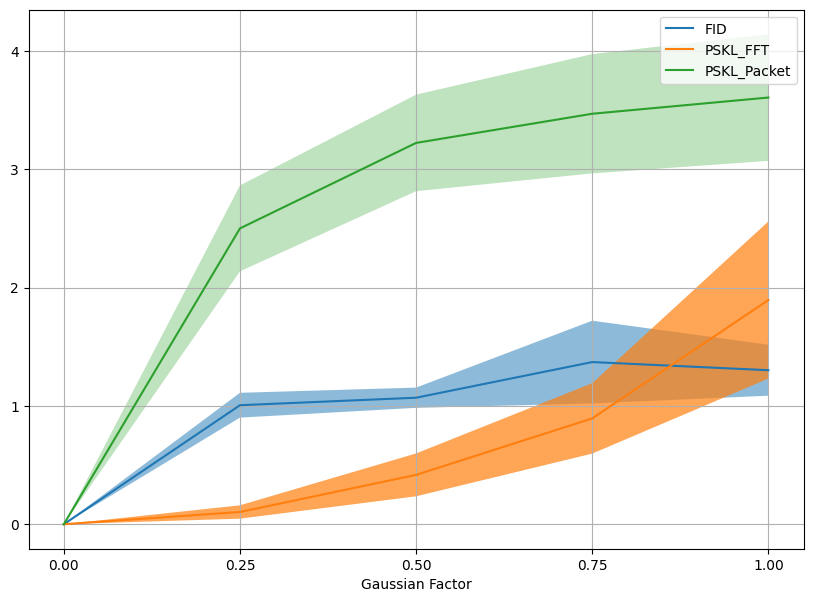

In [252]:
gauss_factors = [0, 0.25, 0.5, 0.75, 1]
all_fids = []
all_ffts = []
all_packets = []
for img_test in [img_test1, img_test2, img_test3, img_test4, img_test5]:
    fids = []
    ffts = []
    packets = []
    print("Factor:", end=' ')
    for fac in gauss_factors:
        fid, fft, packs = gaussian_values(img_test, fac)

        print(f"{fac}", end=', ')
        fids.append(fid)
        ffts.append(sum(fft)/2.)
        packets.append(sum(packs)/2.)
    print()
    all_fids.append(fids)
    all_ffts.append(ffts)
    all_packets.append(packets)
muf, stdf = compute_mean_var(all_fids)
mufft, stdfft = compute_mean_var(all_ffts)
muw, stdw = compute_mean_var(all_packets)
plt.figure(figsize=(10, 7))
plt.plot(gauss_factors, muf, label='FID')
plt.fill_between(gauss_factors, muf-stdf, muf+stdf, alpha=0.5)
plt.plot(gauss_factors, mufft, label='PSKL_FFT')
plt.fill_between(gauss_factors, mufft-stdfft, mufft+stdfft, alpha=0.7)
plt.plot(gauss_factors, muw, label='PSKL_Packet')
plt.fill_between(gauss_factors, muw-stdw, muw+stdw, alpha=0.3)
plt.xticks(gauss_factors)
plt.xlabel('Gaussian Factor')
plt.grid()
plt.gca().legend()
plt.savefig('metrics_v_gaussian.pdf', dpi=600, bbox_inches='tight')
plt.show()

Kernel Size: 1, 3, 5, 7, 9, 11, 
Kernel Size: 1, 3, 5, 7, 9, 11, 
Kernel Size: 1, 3, 5, 7, 9, 11, 
Kernel Size: 1, 3, 5, 7, 9, 11, 
Kernel Size: 1, 3, 5, 7, 9, 11, 


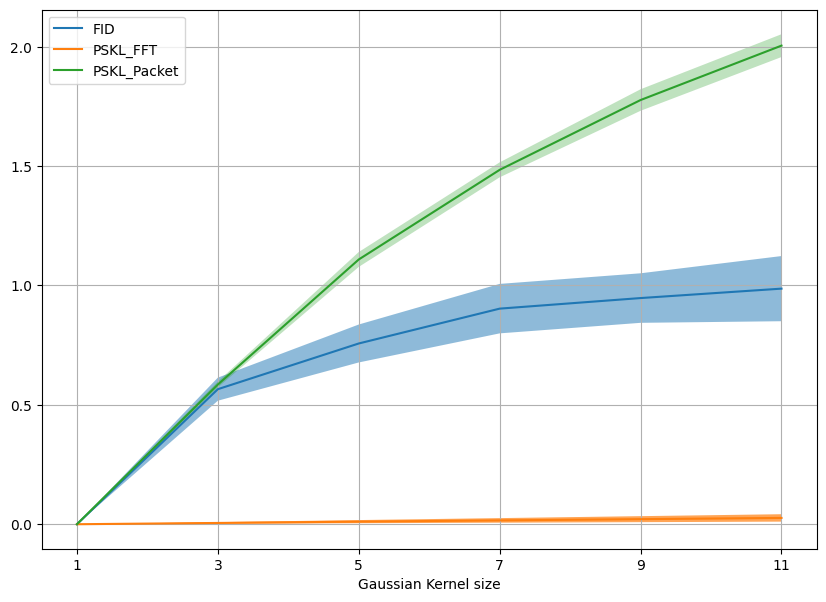

In [257]:
kernel_size = [1, 3, 5, 7, 9, 11]
all_fids = []
all_ffts = []
all_packets = []
for img_test in [img_test1, img_test2, img_test3, img_test4, img_test5]:
    fids = []
    ffts = []
    packets = []
    print("Kernel Size:", end=' ')
    for ker in kernel_size:
        fid, fft, packs = gaussianBlur_values(img_test, ker)

        print(f"{ker}", end=', ')
        fids.append(fid)
        ffts.append(sum(fft)/2.)
        packets.append(sum(packs)/2.)
    print()
    all_fids.append(fids)
    all_ffts.append(ffts)
    all_packets.append(packets)
muf, stdf = compute_mean_var(all_fids)
mufft, stdfft = compute_mean_var(all_ffts)
muw, stdw = compute_mean_var(all_packets)
plt.figure(figsize=(10, 7))
plt.plot(kernel_size, muf, label='FID')
plt.fill_between(kernel_size, muf-stdf, muf+stdf, alpha=0.5)
plt.plot(kernel_size, mufft, label='PSKL_FFT')
plt.fill_between(kernel_size, mufft-stdfft, mufft+stdfft, alpha=0.7)
plt.plot(kernel_size, muw, label='PSKL_Packet')
plt.fill_between(kernel_size, muw-stdw, muw+stdw, alpha=0.3)
plt.xticks(kernel_size)
plt.xlabel('Gaussian Kernel size')
plt.grid()
plt.gca().legend()
plt.savefig('metrics_v_gaussianBlur.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [260]:
comp_path = './compression_samples/'
os.makedirs(comp_path, exist_ok=True)

In [262]:
png_path = os.path.join(comp_path, 'png/')
os.makedirs(png_path, exist_ok=True)

In [265]:
for idx, img in enumerate([img_test1, img_test2, img_test3, img_test4, img_test5]):
    fn = os.path.join(png_path, f'{idx+1:05d}.png')
    img.save(fn)


In [266]:
comp_rate = [10, 25, 50, 75]
for rate in comp_rate:
    compr_path =os.path.join(comp_path, f'{rate}/')
    os.makedirs(compr_path, exist_ok=True)

    for idx, img in enumerate([img_test1, img_test2, img_test3, img_test4, img_test5]):
        fn = os.path.join(compr_path, f'{idx+1:05d}.jpg')
        img.save(fn, quality=rate)


In [267]:
def format_values(img_test, imgr_test, n=10):
    img_tensor = transforms.ToTensor()(img_test)
    imgr_tensor = transforms.ToTensor()(imgr_test)
    img_tensor = torch.stack([img_tensor]*n, dim=0)
    imgr_tensor = torch.stack([imgr_tensor]*n, dim=0)
    # print(img_tensor.shape, imgr_tensor.shape)
    bidx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([bidx])
    op1 = model(img_tensor)[0]
    op2 = model(imgr_tensor)[0]
    onp1 = op1.squeeze(3).squeeze(2).cpu().numpy()
    onp2 = op2.squeeze(3).squeeze(2).cpu().numpy()
    m1, s1 = np.mean(onp1, axis=0), np.cov(onp1, rowvar=False)
    m2, s2 = np.mean(onp2, axis=0), np.cov(onp2, rowvar=False)
    fid = calculate_frechet_distance(m1, s1, m2, s2)
    fa, fb = fourier_power_divergence(img_tensor, imgr_tensor)
    pa, pb = wavelet_packet_power_divergence(img_tensor, imgr_tensor, level=2)
    return fid, (fa.item(), fb.item()), (pa.item(), pb.item())
    

In [275]:
def read_imgs(rate):
    compr_path =os.path.join(comp_path, f'{rate}/')
    img_nms = glob.glob(f'{compr_path}*.jpg') if isinstance(rate, int) else glob.glob(f'{compr_path}*.png')
    assert len(img_nms) == 5
    imgs = []
    for nm in img_nms:
        imgs.append(Image.open(nm))
    return imgs
comp_imgs = {
    10: read_imgs(10),
    25: read_imgs(25),
    50: read_imgs(50),
    75: read_imgs(75),
    100: read_imgs('png')
}

Rate: 10, 25, 50, 75, 100, 
Rate: 10, 25, 50, 75, 100, 
Rate: 10, 25, 50, 75, 100, 
Rate: 10, 25, 50, 75, 100, 
Rate: 10, 25, 50, 75, 100, 


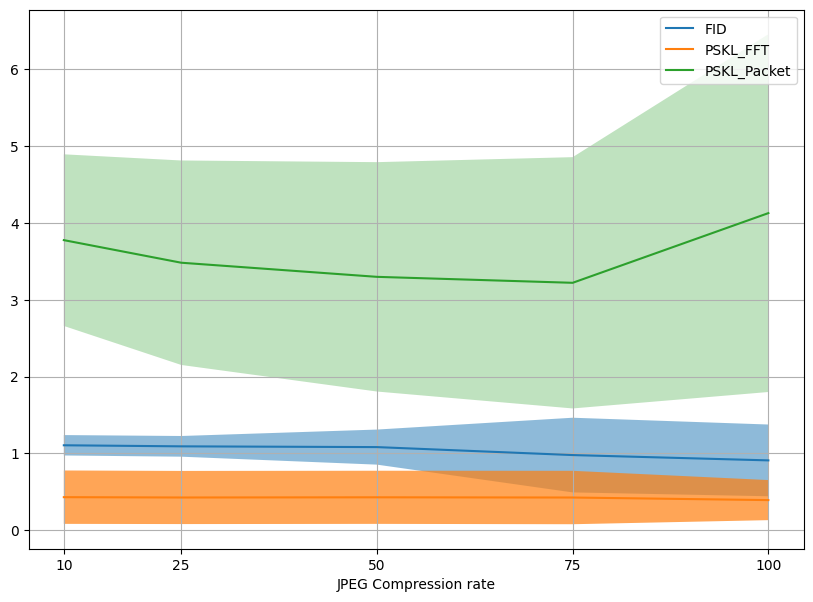

In [276]:
rates = [10, 25, 50, 75, 100]
all_fids = []
all_ffts = []
all_packets = []
for idx, img_test in enumerate([img_test1, img_test2, img_test3, img_test4, img_test5]):
    fids = []
    ffts = []
    packets = []
    print("Rate:", end=' ')
    for rate in rates:
        fid, fft, packs = format_values(img_test, comp_imgs[rate][idx])

        print(f"{rate}", end=', ')
        fids.append(fid)
        ffts.append(sum(fft)/2.)
        packets.append(sum(packs)/2.)
    print()
    all_fids.append(fids)
    all_ffts.append(ffts)
    all_packets.append(packets)
muf, stdf = compute_mean_var(all_fids)
mufft, stdfft = compute_mean_var(all_ffts)
muw, stdw = compute_mean_var(all_packets)
plt.figure(figsize=(10, 7))
plt.plot(rates, muf, label='FID')
plt.fill_between(rates, muf-stdf, muf+stdf, alpha=0.5)
plt.plot(rates, mufft, label='PSKL_FFT')
plt.fill_between(rates, mufft-stdfft, mufft+stdfft, alpha=0.7)
plt.plot(rates, muw, label='PSKL_Packet')
plt.fill_between(rates, muw-stdw, muw+stdw, alpha=0.3)
plt.xticks(rates)
plt.xlabel('JPEG Compression rate')
plt.grid()
plt.gca().legend()
plt.savefig('metrics_v_comprate.pdf', dpi=600, bbox_inches='tight')
plt.show()